In [1]:
import numpy as np
import pickle
import copy

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
input_filename='/scratch/gpfs/jabbate/mixed_data/final_data_batch_150.pkl'
with open(input_filename, 'rb') as f: 
    raw_data=pickle.load(f, encoding='latin1')

In [76]:
number=33
letter='L'
raw_data[170716]['target_source_pinj_{}{}'.format(number,letter)]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [3]:
from helpers.data_generator import process_data, DataGenerator

Using TensorFlow backend.


In [4]:
#import importlib
#importlib.reload(helpers.data_generator)
lookbacks={'dens':0,'temp':0,'density_estimate':6,'target_density':6,'gasA':6,'pinj':6,'realtime_betan':6,'beam_target_power':6}
lookahead=3
traindata, valdata, normalization_dict = process_data('/scratch/gpfs/jabbate/mixed_data/final_data_batch_150.pkl', #scenario['raw_data_path'],
                                                      list(lookbacks.keys()), #sig names
                                                      'RobustScaler',
                                                      1, #window length
                                                      0, #window overlap
                                                      lookbacks, #lookbacks
                                                      lookahead, #lookahead
                                                      1, #sample step
                                                      True, #uniform normalization
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      50, #nshots
                                                      2, #verbosity
                                                      True, #flattop only
                                                      randomize=False,
                                                      pruning_functions=['remove_nan','remove_non_gas_feedback','remove_non_beta_feedback']) #pruning_functions, 
                                                      #excluded_shots = scenario['excluded_shots'],
                                                        
train_generator = DataGenerator(traindata,
                                1, #scenario['batch_size'],
                                ['temp','dens'], #input profiles
                                ['target_density','beam_target_power','gasA','pinj'], #actuators
                                ['temp','dens'], #target profile names
                                ['density_estimate','realtime_betan'], #scalar inputs
                                lookbacks, #lookbacks
                                lookahead,
                                True, #predict deltas
                                2, #profile_downsample
                                False) #scenario['shuffle_generators'])

Loading
Signals: beam_target_power, dens, density_estimate, gasA, pinj, realtime_betan, target_density, temp
Number of useable shots:  49
Number of shots used:  49
Total number of timesteps:  12736
Shots with Complete NaN: 
8532 samples total
Removing timesteps WITHOUT gas feedback
Removed 1730 samples
6802 samples remaining
Removing timesteps WITHOUT betan feedback
Removed 4396 samples
2406 samples remaining
Removing NaN
Removed 0 samples
2406 samples remaining
2406 samples remaining after pruning
Total number of samples:  2406
Number of training samples:  2406
Number of validation samples:  0


In [5]:
traindata['dens'].shape

(2406, 4, 65)

In [6]:
pre_pca=traindata['temp'][:,-1,:]

In [7]:
from sklearn import preprocessing
from sklearn import decomposition

In [8]:
pre_pca_normalized=pre_pca #preprocessing.scale(pre_pca)

In [9]:
pca=decomposition.PCA(n_components=3)
pca.fit(pre_pca_normalized)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

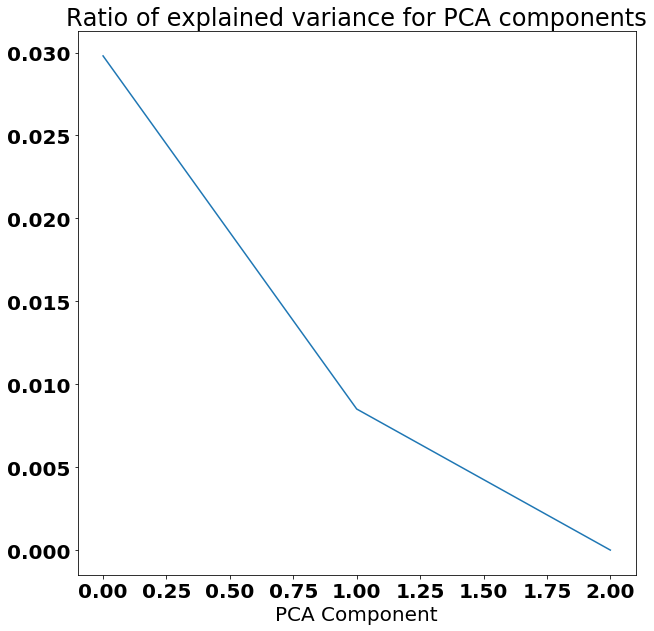

In [10]:
plt.rcParams['figure.figsize'] = [10, 10]
font={'size': 20, 'weight':'heavy'}
plt.rc('font', **font)

plt.plot(np.sum(pca.explained_variance_ratio_)-np.cumsum(pca.explained_variance_ratio_))
plt.title('Ratio of explained variance for PCA components')
plt.xlabel('PCA Component')
plt.show()

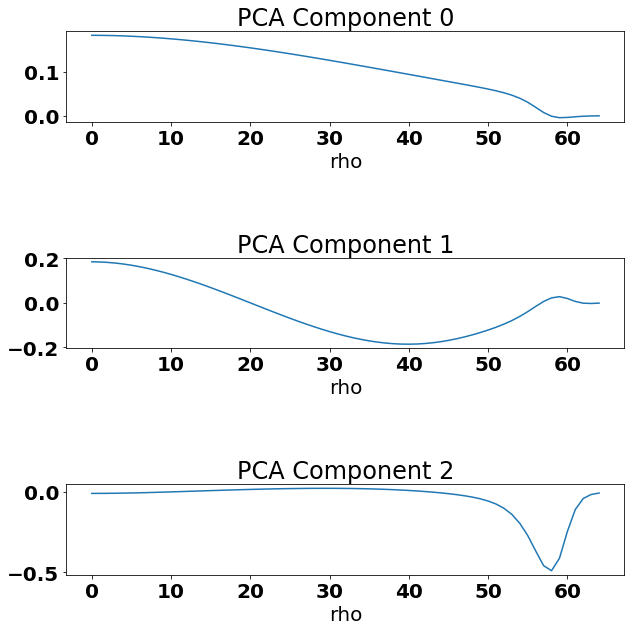

In [11]:
plt.rcParams['figure.figsize'] = [10, 10]
font={'size': 20, 'weight':'heavy'}
plt.rc('font', **font)

fig=plt.figure()
num_plots=min(9,len(pca.components_))
for i in range(num_plots):
    ax=fig.add_subplot('{}{}{}'.format(num_plots,1,i+1))
    ax.plot(pca.components_[i])
    ax.set_title('PCA Component {}'.format(i))
    ax.set_xlabel('rho')
plt.xlabel('rho',fontsize=20)
plt.subplots_adjust(hspace=1.5)

In [12]:
pca_data=pca.transform(pre_pca_normalized)

In [22]:
thomson_pca=pca.transform(data[0]['thomson_temp_EFITRT1'][:,-1,:])

NameError: name 'data' is not defined

Index 1481



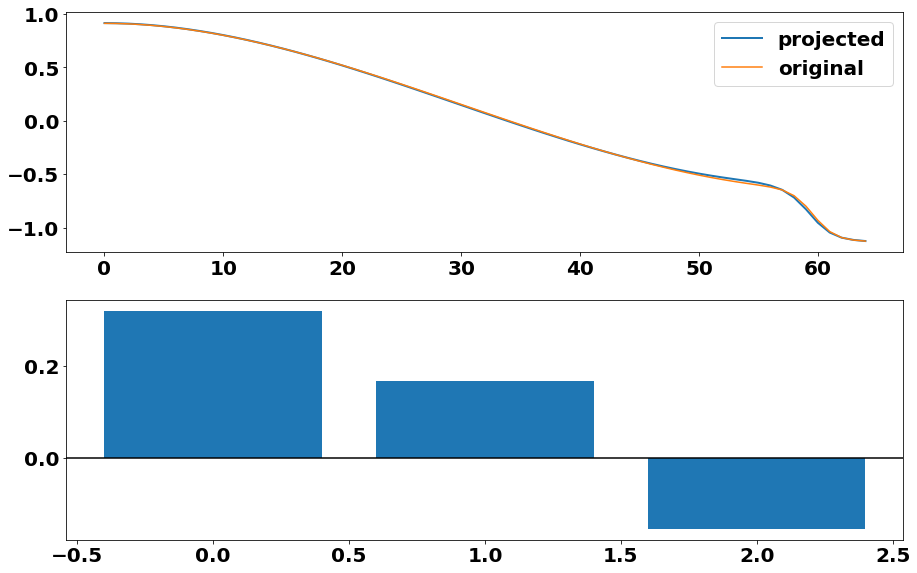

In [13]:
plt.rcParams['figure.figsize'] = [15, 15]
font={'size': 20, 'weight':'heavy'}
plt.rc('font', **font)

fig=plt.figure()
ind=np.random.choice(len(pca_data))
ax=fig.add_subplot('311')
ax.plot(pca.inverse_transform(pca_data[ind]),label='projected',linewidth=2)
ax.plot(pre_pca_normalized[ind],label='original')
#ax.plot(data[0]['thomson_temp_EFITRT1'][ind,-1,:],label='thomson')
#ax.plot(pca.inverse_transform(thomson_pca[ind]),label='projected thomson',linewidth=2)
ax.legend()

ax=fig.add_subplot('312')
ax.bar([i for i  in range(len(pca_data[ind]))],pca_data[ind])
ax.axhline(0,color='k')

#ax=fig.add_subplot('313')
#ax.bar([i for i  in range(len(thomson_pca[ind]))],thomson_pca[ind])
#ax.axhline(0,color='k')

print('Index {}\n'.format(ind))

plt.show()

In [69]:
pre_pca_normalized.shape
pca_data.shape

(1789, 3)

In [22]:
traindata['shotnum'].shape

(2406, 10)

In [26]:
allshots=np.unique(traindata['shotnum'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]),)

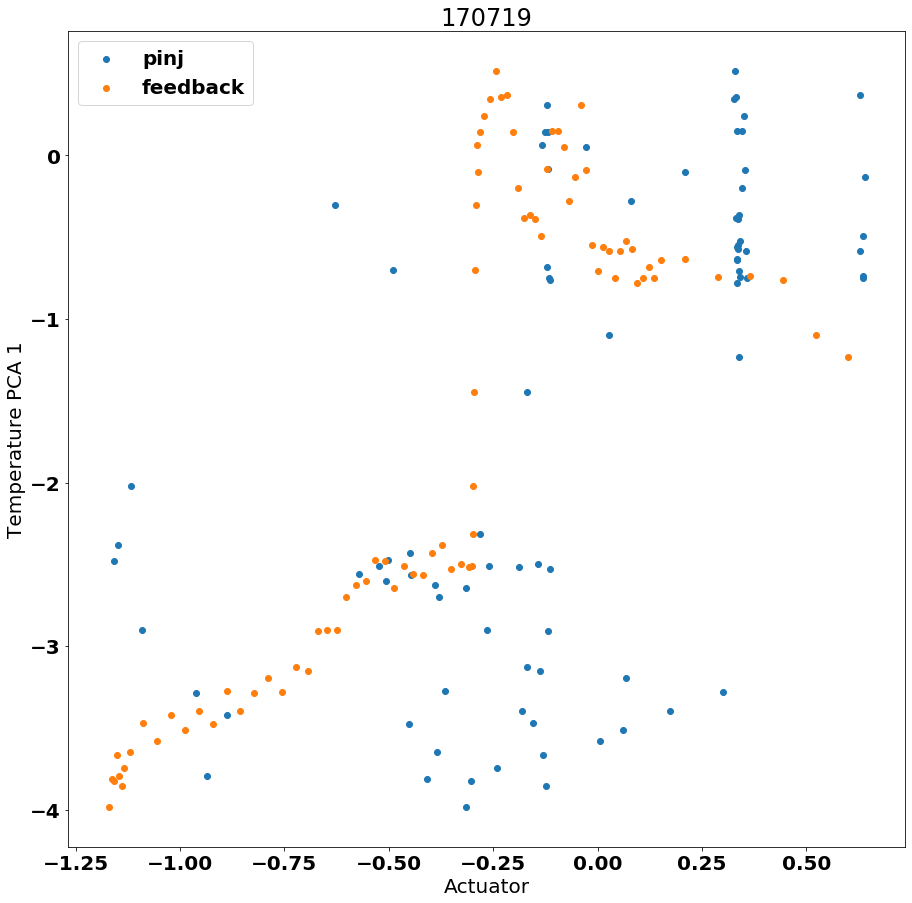

In [77]:
shot=np.random.choice(allshots)
inds=np.where(traindata['shotnum'][:,0]==shot)

#output=pca_data[inds,0]

plt.scatter(traindata['pinj'][inds,-1],pca_data[inds,0],label='pinj')
plt.scatter(traindata['beam_target_power'][inds,-1],pca_data[inds,0],label='feedback')
plt.legend()
plt.ylabel('Temperature PCA 1')
plt.xlabel('Actuator')
plt.title(int(shot))
plt.show()